In [67]:
import cv2
from PIL import Image, ImageDraw, ImageFont

import yaml
import pandas as pd
import os
import random
import shutil

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

# Предобработка Train и Valid

## Изначальный датасет

In [5]:
display(len(os.listdir('A:/PythonProjects/RAILROAD/dataset/train/v2s/train/images')))
display(len(os.listdir('A:/PythonProjects/RAILROAD/dataset/train/v2s/train/labels')))

display(len(os.listdir('A:/PythonProjects/RAILROAD/dataset/train/v2s/valid/images')))
display(len(os.listdir('A:/PythonProjects/RAILROAD/dataset/train/v2s/valid/labels')))

77066

82330

8490

8453

In [6]:
def check_labels():
    deers_labels = {
        'Файл': [],
        'Папка': [],
        'Класс': [],
        'bbox': []
    }

    for folder in ['train', 'valid']:
        for filename in os.listdir(f'{folder}/labels'):
            if filename.endswith('.txt'):
                file_path = os.path.join(f'{folder}/labels', filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    lines = file.readlines()
                    if not lines:
                        deers_labels['Файл'].append(filename)
                        deers_labels['Папка'].append(folder.split('/')[-1])
                        deers_labels['Класс'].append(None)
                        deers_labels['bbox'].append(0)
                    else:
                        for line in lines:
                            deers_labels['Файл'].append(filename)
                            deers_labels['Папка'].append(folder.split('/')[-1])
                            deers_labels['Класс'].append(line.split(' ')[0])
                            deers_labels['bbox'].append(len(line.split(' ')))

    deers_labels = pd.DataFrame(deers_labels)
    return deers_labels

deers_labels = check_labels()
deers_labels.head()

,Файл,Папка,Класс,bbox
0,-1-_jpg.rf.3e04c389be269c36666846cb00b81899.txt,train,2,5
1,-1-_jpg.rf.3e04c389be269c36666846cb00b81899.txt,train,2,5
2,-1-_jpg.rf.495fc7f47d2a38df7dd555fe196b9f56.txt,train,2,5
3,-1-_jpg.rf.495fc7f47d2a38df7dd555fe196b9f56.txt,train,2,5
4,-1-_jpg.rf.7c3815b9351f9dbf87664a9fd4ee9226.txt,train,2,5


In [7]:
names = {0: 'cattle', 1: 'human', 2: 'vehicle'}
colors = {label: list(np.random.random(size=3) * 256) for i, label in enumerate(set([int(key) for key in names.keys()]))}
deers_labels_gr = deers_labels.groupby(['Папка', 'Класс'], as_index=False).size().sort_values('Класс', ascending=True)
deers_labels_gr['Класс_name'] = deers_labels_gr['Класс'].apply(lambda x: names[int(x)])

fig_class_1 = px.histogram(
    data_frame=deers_labels_gr,
    y='size',
    x='Класс_name',
    color='Папка',
    text_auto=True
    )

fig_class_1.update_layout(title_text='<b>Распределение меток в данных</b>', title_x=0.5, height=500, yaxis = {"title": 'Количество меток'})
fig_class_1.show()

### Удаление разметки и изображений с классом 0 (Животные)

In [ ]:
def remove_files_using_dataframe(deers_labels):
    # Находим все уникальные файлы, где есть класс 0
    files_with_zero = deers_labels[deers_labels['Класс'] == '0']['Файл'].unique()
    
    removed_count = 0
    
    for filename in files_with_zero:
        base_name = os.path.splitext(filename)[0]
        
        # Для каждого файла находим соответствующую папку
        folders = deers_labels[deers_labels['Файл'] == filename]['Папка'].unique()
        
        for folder in folders:
            labels_dir = os.path.join(folder, 'labels')
            images_dir = os.path.join(folder, 'images')
            
            txt_file = os.path.join(labels_dir, filename)
            # Проверяем возможные форматы изображений
            for ext in ['.jpg', '.jpeg', '.png']:
                img_file = os.path.join(images_dir, f"{base_name}{ext}")
                if os.path.exists(img_file):
                    try:
                        os.remove(txt_file)
                        os.remove(img_file)
                        print(f"Удалено: {txt_file} и {img_file}")
                        removed_count += 1
                    except Exception as e:
                        print(f"Ошибка при удалении {txt_file} или {img_file}: {e}")
                    break
    
    return removed_count

removed_count = remove_files_using_dataframe(deers_labels)

### Удаление файлов без пары (изображение и разметка)

In [ ]:
def check_and_clean_directories(labels_dir, images_dir):
    # Получаем список файлов в папках labels и images
    labels_files = set(os.listdir(labels_dir))
    images_files = set(os.listdir(images_dir))

    # Извлекаем имена файлов без расширений
    labels_names = {os.path.splitext(file)[0] for file in labels_files if file.endswith('.txt')}
    images_names = {os.path.splitext(file)[0] for file in images_files if file.endswith('.jpg')}

    display(len(labels_names))
    display(len(images_names))

    # Находим файлы без пары
    labels_without_pair = labels_names - images_names
    images_without_pair = images_names - labels_names

    display(labels_without_pair)
    display(images_without_pair)

    # Удаляем файлы без пары
    for label in labels_without_pair:
        file_path = os.path.join(labels_dir, f"{label}.txt")
        os.remove(file_path)
        #print(f"Deleted label file: {file_path}")

    for image in images_without_pair:
        file_path = os.path.join(images_dir, f"{image}.jpg")
        os.remove(file_path)
        #print(f"Deleted image file: {file_path}")

labels_dir = 'A:/PythonProjects/RAILROAD/dataset/train/v2s/train/labels'
images_dir = 'A:/PythonProjects/RAILROAD/dataset/train/v2s/train/images'
check_and_clean_directories(labels_dir, images_dir)

labels_dir = 'A:/PythonProjects/RAILROAD/dataset/train/v2s/valid/labels'
images_dir = 'A:/PythonProjects/RAILROAD/dataset/train/v2s/valid/images'
check_and_clean_directories(labels_dir, images_dir)

In [12]:
deers_labels = check_labels()
display(deers_labels.head())
display(deers_labels['Класс'].unique())

,Файл,Папка,Класс,bbox
0,-1-_jpg.rf.3e04c389be269c36666846cb00b81899.txt,train,2,5
1,-1-_jpg.rf.3e04c389be269c36666846cb00b81899.txt,train,2,5
2,-1-_jpg.rf.495fc7f47d2a38df7dd555fe196b9f56.txt,train,2,5
3,-1-_jpg.rf.495fc7f47d2a38df7dd555fe196b9f56.txt,train,2,5
4,-1-_jpg.rf.7c3815b9351f9dbf87664a9fd4ee9226.txt,train,2,5


array(['2', '1'], dtype=object)

In [13]:
names = {0: 'cattle', 1: 'human', 2: 'vehicle'}
colors = {label: list(np.random.random(size=3) * 256) for i, label in enumerate(set([int(key) for key in names.keys()]))}
deers_labels_gr = deers_labels.groupby(['Папка', 'Класс'], as_index=False).size().sort_values('Класс', ascending=True)
deers_labels_gr['Класс_name'] = deers_labels_gr['Класс'].apply(lambda x: names[int(x)])

fig_class_1 = px.histogram(
    data_frame=deers_labels_gr,
    y='size',
    x='Класс_name',
    color='Папка',
    text_auto=True
    )

fig_class_1.update_layout(title_text='<b>Распределение меток в данных</b>', title_x=0.5, height=500, yaxis = {"title": 'Количество меток'})
fig_class_1.show()

In [45]:
def draw_bbox(image_path, annotation_path, names):
    class_colors = {
        0: (255, 50, 50),
        1: (50, 255, 50),
        2: (50, 50, 255)
    }
    
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Ошибка загрузки изображения: {e}")
        return

    draw = ImageDraw.Draw(image)
    
    try:
        with open(annotation_path, 'r') as f:
            annotations = f.readlines()
    except Exception as e:
        print(f"Ошибка загрузки аннотаций: {e}")
        return

    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except:
        font = ImageFont.load_default()

    for annotation in annotations:
        parts = annotation.strip().split()
        if len(parts) != 5:
            continue
            
        label, x_center, y_center, width, height = parts
        label = int(label)
        
        if label not in names or label not in class_colors:
            continue
            
        x_center, y_center, width, height = map(float, [x_center, y_center, width, height])
        img_width, img_height = image.size
        
        x = int((x_center - width/2) * img_width)
        y = int((y_center - height/2) * img_height)
        box_width = int(width * img_width)
        box_height = int(height * img_height)
        
        color = class_colors[label]
        
        draw.rectangle(
            [(x, y), (x + box_width, y + box_height)],
            outline=color,
            width=2
        )
        
        text = f"{label}: {names[label]}"
        left, top, right, bottom = font.getbbox(text)
        text_width = right - left
        text_height = bottom - top
        
        draw.rectangle(
            [(x, y - text_height - 2), (x + text_width, y)],
            fill=color
        )
        draw.text(
            (x, y - text_height - 2),
            text,
            fill="white",
            font=font
        )

    plt.imshow(image)
    plt.axis('off')
    plt.show()

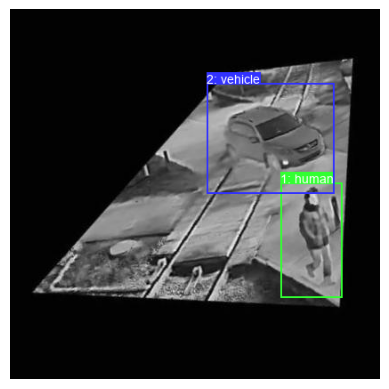

In [46]:
names = {0: 'cattle', 1: 'human', 2: 'vehicle'}
draw_bbox('A:/PythonProjects/RAILROAD/dataset/train/v2s/train/images/3_dgizPp_jpg.rf.ff6ba031372fdc53e06b861bcd0b2a22.jpg',
          'A:/PythonProjects/RAILROAD/dataset/train/v2s/train/labels/3_dgizPp_jpg.rf.ff6ba031372fdc53e06b861bcd0b2a22.txt', 
          names)

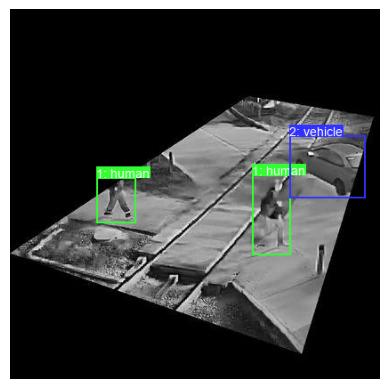

In [47]:
draw_bbox('A:/PythonProjects/RAILROAD/dataset/train/v2s/valid/images/3_FLKbfU_jpg.rf.1ac8e28263c11340b01b688bc27d4031.jpg',
          'A:/PythonProjects/RAILROAD/dataset/train/v2s/valid/labels/3_FLKbfU_jpg.rf.1ac8e28263c11340b01b688bc27d4031.txt', 
          names)

### Замена классов в разметке

In [58]:
# Заменяем классы
def reclassify_labels(reclass):
    for folder in ['A:/PythonProjects/RAILROAD/dataset/train/v2s/train', 'A:/PythonProjects/RAILROAD/dataset/train/v2s/valid']:
        for filename in os.listdir(f'{folder}/labels'):
            if filename.endswith('.txt'):
                file_path = os.path.join(f'{folder}/labels', filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    lines = file.readlines()

                with open(file_path, 'w', encoding='utf-8') as file:
                    for line in lines:
                        class_id = int(line.split(' ')[0])
                        new_class_id = reclass.get(class_id, class_id)
                        file.write(f'{new_class_id} {" ".join(line.split(" ")[1:])}')

reclass = {1: 0, 2: 1}
reclassify_labels(reclass)

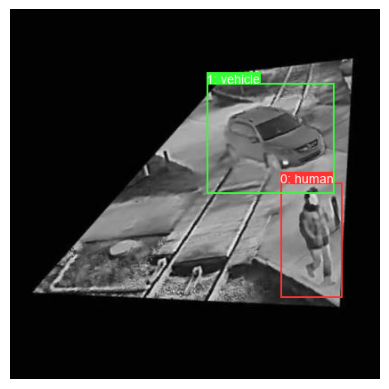

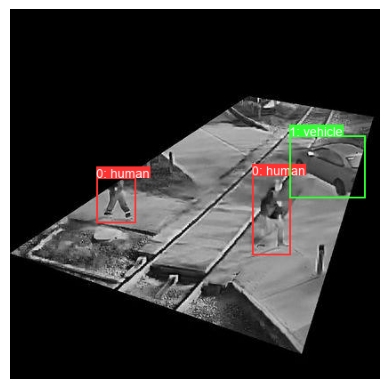

In [59]:
names = {0: 'human', 1: 'vehicle'}
draw_bbox('A:/PythonProjects/RAILROAD/dataset/train/v2s/train/images/3_dgizPp_jpg.rf.ff6ba031372fdc53e06b861bcd0b2a22.jpg',
          'A:/PythonProjects/RAILROAD/dataset/train/v2s/train/labels/3_dgizPp_jpg.rf.ff6ba031372fdc53e06b861bcd0b2a22.txt', 
          names)

draw_bbox('A:/PythonProjects/RAILROAD/dataset/train/v2s/valid/images/3_FLKbfU_jpg.rf.1ac8e28263c11340b01b688bc27d4031.jpg',
          'A:/PythonProjects/RAILROAD/dataset/train/v2s/valid/labels/3_FLKbfU_jpg.rf.1ac8e28263c11340b01b688bc27d4031.txt', 
          names)

## Чернь

In [26]:
def check_labels():
    deers_labels = {
        'Файл': [],
        'Папка': [],
        'Класс': [],
        'bbox': []
    }

    for folder in ['CH']:
        for filename in os.listdir(f'{folder}/labels'):
            if filename.endswith('.txt'):
                file_path = os.path.join(f'{folder}/labels', filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    lines = file.readlines()
                    if not lines:
                        deers_labels['Файл'].append(filename)
                        deers_labels['Папка'].append(folder.split('/')[-1])
                        deers_labels['Класс'].append(None)
                        deers_labels['bbox'].append(0)
                    else:
                        for line in lines:
                            deers_labels['Файл'].append(filename)
                            deers_labels['Папка'].append(folder.split('/')[-1])
                            deers_labels['Класс'].append(line.split(' ')[0])
                            deers_labels['bbox'].append(len(line.split(' ')))

    deers_labels = pd.DataFrame(deers_labels)
    return deers_labels

deers_labels = check_labels()
deers_labels.head()

,Файл,Папка,Класс,bbox
0,crossing_20250503_000852_603091.txt,CH,1,5
1,crossing_20250503_000854_039585.txt,CH,1,5
2,crossing_20250503_000953_849186.txt,CH,1,5
3,crossing_20250503_000957_868324.txt,CH,1,5
4,crossing_20250503_001833_741030.txt,CH,1,5


In [50]:
names = {0: 'human', 1: 'vehicle'}
deers_labels_gr = deers_labels.groupby(['Папка', 'Класс'], as_index=False).size().sort_values('Класс', ascending=True)
deers_labels_gr['Класс_name'] = deers_labels_gr['Класс'].apply(lambda x: names[int(x)])

fig_class_1 = px.histogram(
    data_frame=deers_labels_gr,
    y='size',
    x='Класс_name',
    color='Папка',
    text_auto=True
    )

fig_class_1.update_layout(title_text='<b>Распределение меток в данных</b>', title_x=0.5, height=500, yaxis = {"title": 'Количество меток'})
fig_class_1.show()

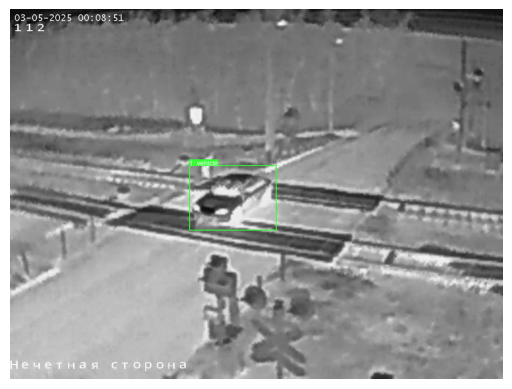

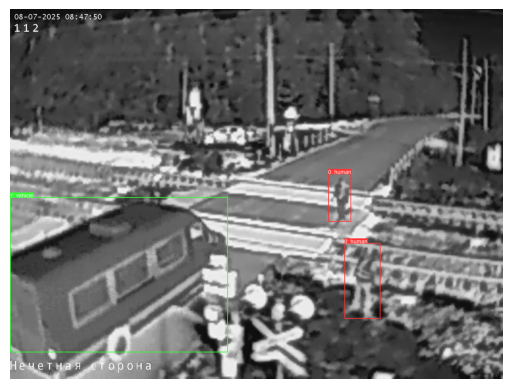

In [60]:
draw_bbox('A:/PythonProjects/RAILROAD/dataset/train/v2s/CH/images/crossing_20250503_000852_603091.jpg',
          'A:/PythonProjects/RAILROAD/dataset/train/v2s/CH/labels/crossing_20250503_000852_603091.txt',
          names)

draw_bbox('A:/PythonProjects/RAILROAD/dataset/train/v2s/CH/images/MЧ_1_1.mp4_frame_495_time_245.51s.jpg',
          'A:/PythonProjects/RAILROAD/dataset/train/v2s/CH/labels/MЧ_1_1.mp4_frame_495_time_245.51s.txt', 
          names)

## Думчино

In [53]:
def check_labels():
    deers_labels = {
        'Файл': [],
        'Папка': [],
        'Класс': [],
        'bbox': []
    }

    for folder in ['DUM']:
        for filename in os.listdir(f'{folder}/labels'):
            if filename.endswith('.txt'):
                file_path = os.path.join(f'{folder}/labels', filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    lines = file.readlines()
                    if not lines:
                        deers_labels['Файл'].append(filename)
                        deers_labels['Папка'].append(folder.split('/')[-1])
                        deers_labels['Класс'].append(None)
                        deers_labels['bbox'].append(0)
                    else:
                        for line in lines:
                            deers_labels['Файл'].append(filename)
                            deers_labels['Папка'].append(folder.split('/')[-1])
                            deers_labels['Класс'].append(line.split(' ')[0])
                            deers_labels['bbox'].append(len(line.split(' ')))

    deers_labels = pd.DataFrame(deers_labels)
    return deers_labels

deers_labels = check_labels()
deers_labels.head()

,Файл,Папка,Класс,bbox
0,МД_1_1.mp4_frame_0_time_0.00s.txt,DUM,1,5
1,МД_1_1.mp4_frame_0_time_0.00s.txt,DUM,1,5
2,МД_1_1.mp4_frame_1000_time_202.38s.txt,DUM,0,5
3,МД_1_1.mp4_frame_1001_time_202.58s.txt,DUM,0,5
4,МД_1_1.mp4_frame_1002_time_202.78s.txt,DUM,0,5


In [54]:
names = {0: 'human', 1: 'vehicle'}
deers_labels_gr = deers_labels.groupby(['Папка', 'Класс'], as_index=False).size().sort_values('Класс', ascending=True)
deers_labels_gr['Класс_name'] = deers_labels_gr['Класс'].apply(lambda x: names[int(x)])

fig_class_1 = px.histogram(
    data_frame=deers_labels_gr,
    y='size',
    x='Класс_name',
    color='Папка',
    text_auto=True
    )

fig_class_1.update_layout(title_text='<b>Распределение меток в данных</b>', title_x=0.5, height=500, yaxis = {"title": 'Количество меток'})
fig_class_1.show()

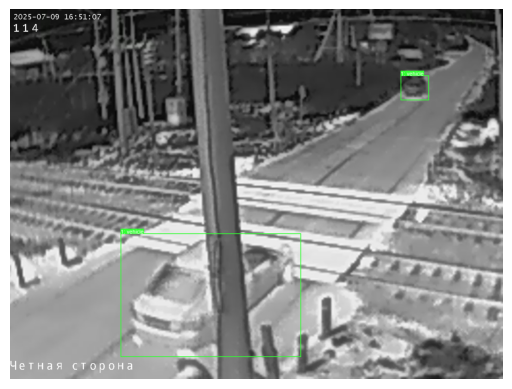

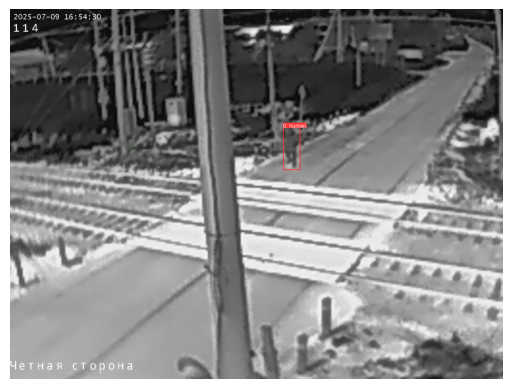

In [61]:
draw_bbox('A:/PythonProjects/RAILROAD/dataset/train/v2s/DUM/images/МД_1_1.mp4_frame_0_time_0.00s.jpg',
          'A:/PythonProjects/RAILROAD/dataset/train/v2s/DUM/labels/МД_1_1.mp4_frame_0_time_0.00s.txt',
          names)

draw_bbox('A:/PythonProjects/RAILROAD/dataset/train/v2s/DUM/images/МД_1_1.mp4_frame_1001_time_202.58s.jpg',
          'A:/PythonProjects/RAILROAD/dataset/train/v2s/DUM/labels/МД_1_1.mp4_frame_1001_time_202.58s.txt',
          names)

# Преобразования классов для Test

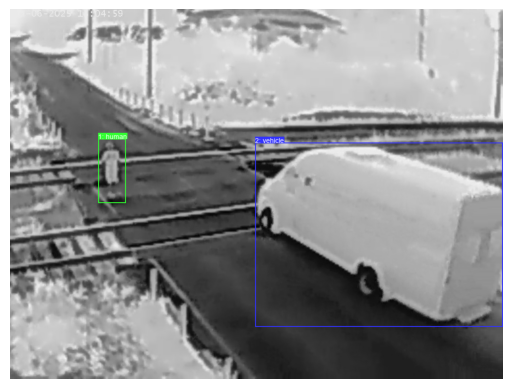

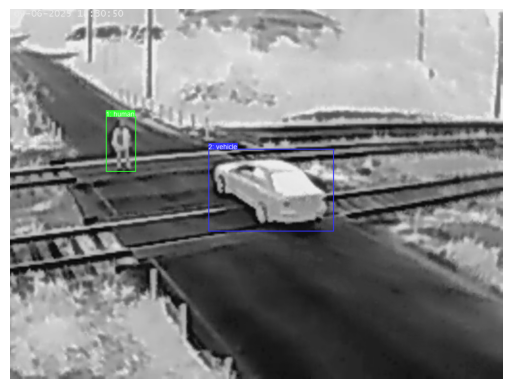

In [63]:
names = {0: 'cattle', 1: 'human', 2: 'vehicle'}
draw_bbox('A:/PythonProjects/RAILROAD/dataset/test/images/3_2025-06-09.mp4_frame_710_time_333.52s.jpg',
          'A:/PythonProjects/RAILROAD/dataset/test/labels/3_2025-06-09.mp4_frame_710_time_333.52s.txt',
          names)

draw_bbox('A:/PythonProjects/RAILROAD/dataset/test/images/5_2025-06-09.mp4_frame_1270_time_597.28s.jpg',
          'A:/PythonProjects/RAILROAD/dataset/test/labels/5_2025-06-09.mp4_frame_1270_time_597.28s.txt',
          names)

In [64]:
def reclassify_labels(reclass):
    for folder in ['A:/PythonProjects/RAILROAD/dataset/test']:
        for filename in os.listdir(f'{folder}/labels'):
            if filename.endswith('.txt'):
                file_path = os.path.join(f'{folder}/labels', filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    lines = file.readlines()

                with open(file_path, 'w', encoding='utf-8') as file:
                    for line in lines:
                        class_id = int(line.split(' ')[0])
                        new_class_id = reclass.get(class_id, class_id)
                        file.write(f'{new_class_id} {" ".join(line.split(" ")[1:])}')

reclass = {1: 0, 2: 1}
reclassify_labels(reclass)

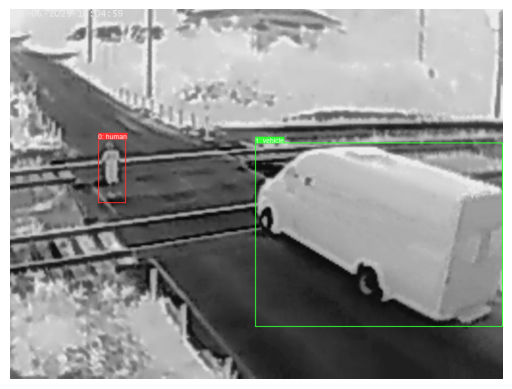

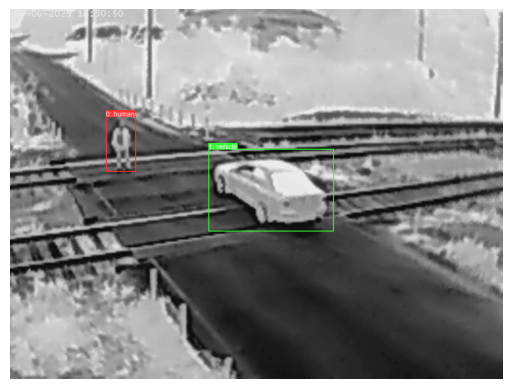

In [65]:
names = {0: 'human', 1: 'vehicle'}
draw_bbox('A:/PythonProjects/RAILROAD/dataset/test/images/3_2025-06-09.mp4_frame_710_time_333.52s.jpg',
          'A:/PythonProjects/RAILROAD/dataset/test/labels/3_2025-06-09.mp4_frame_710_time_333.52s.txt',
          names)

draw_bbox('A:/PythonProjects/RAILROAD/dataset/test/images/5_2025-06-09.mp4_frame_1270_time_597.28s.jpg',
          'A:/PythonProjects/RAILROAD/dataset/test/labels/5_2025-06-09.mp4_frame_1270_time_597.28s.txt',
          names)

# Объединяем в финальной папке распределяя по train и valid

In [68]:
# Пути к датасетам с Чернь и Думчино
ch_path = "A:/PythonProjects/RAILROAD/dataset/train/v2s/CH"
dum_path = "A:/PythonProjects/RAILROAD/dataset/train/v2s/DUM"

# Путь к финальному датасету
final_path = "A:/PythonProjects/RAILROAD/dataset/final"


# Количество изображений для валидации из каждого источника
n_valid = 1000

def copy_samples(source_path, target_path, n, mode="valid"):

    images = [f for f in os.listdir(f"{source_path}/images") if f.endswith(('.jpg', '.png'))]
    random.shuffle(images)
    
    # Копируем в valid
    for img in images[:n]:
        base_name = os.path.splitext(img)[0]
        
        # Копируем изображение
        shutil.copy2(
            f"{source_path}/images/{img}",
            f"{target_path}/{mode}/images/{img}"
        )
        
        # Копируем разметку (если существует)
        label_src = f"{source_path}/labels/{base_name}.txt"
        if os.path.exists(label_src):
            shutil.copy2(
                label_src,
                f"{target_path}/{mode}/labels/{base_name}.txt"
            )
    
    # Копируем остальные в train
    for img in images[n:]:
        base_name = os.path.splitext(img)[0]
        
        shutil.copy2(
            f"{source_path}/images/{img}",
            f"{target_path}/train/images/{img}"
        )
        
        label_src = f"{source_path}/labels/{base_name}.txt"
        if os.path.exists(label_src):
            shutil.copy2(
                label_src,
                f"{target_path}/train/labels/{base_name}.txt"
            )

# Обрабатываем оба датасета
copy_samples(ch_path, final_path, n_valid)
copy_samples(dum_path, final_path, n_valid)

print(f"Train: {len(os.listdir(f'{final_path}/train/images'))} изображений")
print(f"Valid: {len(os.listdir(f'{final_path}/valid/images'))} изображений")

Train: 76422 изображений
Valid: 7983 изображений


In [69]:
def check_labels():
    deers_labels = {
        'Файл': [],
        'Папка': [],
        'Класс': [],
        'bbox': []
    }

    for folder in ['A:/PythonProjects/RAILROAD/dataset/final/train', 'A:/PythonProjects/RAILROAD/dataset/final/valid']:
        for filename in os.listdir(f'{folder}/labels'):
            if filename.endswith('.txt'):
                file_path = os.path.join(f'{folder}/labels', filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    lines = file.readlines()
                    if not lines:
                        deers_labels['Файл'].append(filename)
                        deers_labels['Папка'].append(folder.split('/')[-1])
                        deers_labels['Класс'].append(None)
                        deers_labels['bbox'].append(0)
                    else:
                        for line in lines:
                            deers_labels['Файл'].append(filename)
                            deers_labels['Папка'].append(folder.split('/')[-1])
                            deers_labels['Класс'].append(line.split(' ')[0])
                            deers_labels['bbox'].append(len(line.split(' ')))

    deers_labels = pd.DataFrame(deers_labels)
    return deers_labels

deers_labels = check_labels()
deers_labels.head()

,Файл,Папка,Класс,bbox
0,-1-_jpg.rf.3e04c389be269c36666846cb00b81899.txt,train,1,5
1,-1-_jpg.rf.3e04c389be269c36666846cb00b81899.txt,train,1,5
2,-1-_jpg.rf.495fc7f47d2a38df7dd555fe196b9f56.txt,train,1,5
3,-1-_jpg.rf.495fc7f47d2a38df7dd555fe196b9f56.txt,train,1,5
4,-1-_jpg.rf.7c3815b9351f9dbf87664a9fd4ee9226.txt,train,1,5


In [71]:
names = {0: 'human', 1: 'vehicle'}
deers_labels_gr = deers_labels.groupby(['Папка', 'Класс'], as_index=False).size().sort_values('Класс', ascending=True)
deers_labels_gr['Класс_name'] = deers_labels_gr['Класс'].apply(lambda x: names[int(x)])

fig_class_1 = px.histogram(
    data_frame=deers_labels_gr,
    y='size',
    x='Класс_name',
    color='Папка',
    text_auto=True
    )

fig_class_1.update_layout(title_text='<b>Распределение меток результирующего датасета</b>', title_x=0.5, height=500, yaxis = {"title": 'Количество меток'}, xaxis = {"title": 'Наименование класса'})
fig_class_1.show()